# **Cloning the repository**

Cloned the actual repository
(https://github.com/VAST-AI-Research/TripoSR)
 to modify to add all the dependencies in it's *requirements.txt* file


In [1]:
!git clone https://github.com/akshith120/TripoSR
%cd "/content/TripoSR"

Cloning into 'TripoSR'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 164 (delta 64), reused 42 (delta 42), pack-reused 66 (from 1)
Receiving objects: 100% (164/164), 36.71 MiB | 35.56 MiB/s, done.
Resolving deltas: 100% (66/66), done.
/content/TripoSR


# Installing all require Dependencies

In [2]:
!pip install -r requirements.txt

  Cloning https://github.com/tatsy/torchmcubes.git to /tmp/pip-req-build-j8i0hek6
  Running command git clone --filter=blob:none --quiet https://github.com/tatsy/torchmcubes.git /tmp/pip-req-build-j8i0hek6
  Resolved https://github.com/tatsy/torchmcubes.git to commit 3381600ddc3d2e4d74222f8495866be5fafbace4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/openai/shap-e.git to /tmp/pip-install-ub7xq6wo/shap-e_fc142d96e64d42479f12e3da695b4e48
  Running command git clone --filter=blob:none --quiet https://github.com/openai/shap-e.git /tmp/pip-install-ub7xq6wo/shap-e_fc142d96e64d42479f12e3da695b4e48
  Resolved https://github.com/openai/shap-e.git to commit 50131012ee11c9d2617f3886c10f000d3c7a3b43
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12

# CUDA version Requirement for TripoSR

In [1]:
print("🔍 PyTorch version:", torch.__version__)
print("🧠 CUDA available:", torch.cuda.is_available())

✅ CUDA is available. PyTorch should already be using the GPU.
🔍 PyTorch version: 2.6.0+cu124
🧠 CUDA available: True


In [2]:
%cd "/content/TripoSR"

/content/TripoSR


# Helper Functions


In [8]:
import os
import torch
from PIL import Image
from pathlib import Path
from rembg import remove
import subprocess
import trimesh
import pyrender
import matplotlib.pyplot as plt

# ==== SETUP ====
os.environ['PYOPENGL_PLATFORM'] = 'egl'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create output folders
'''
Output Folder to hold Generated 3D models

'''
Path("outputs/text_input").mkdir(parents=True, exist_ok=True)
Path("outputs/image_input").mkdir(parents=True, exist_ok=True)

def visualize_obj(obj_path):
  # Helper Function #1 : For Simple Visualisation of generated 3D models
    try:
        mesh = trimesh.load(obj_path)
        scene = pyrender.Scene()
        mesh_node = pyrender.Mesh.from_trimesh(mesh)
        scene.add(mesh_node)
        pyrender.Viewer(scene, use_raymond_lighting=True)
    except Exception as e:
        print(f"⚠️ Could not visualize: {e}")

# ==== SHAP-E PART (TEXT TO 3D) ====
def run_shapee_text_to_3d(prompt: str):
    print("🔠 Running Shap-E (Text-to-3D)...")
    from shap_e.diffusion.sample import sample_latents
    from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
    from shap_e.models.download import load_model, load_config
    from shap_e.util.notebooks import decode_latent_mesh

    model = load_model('text300M', device=device)
    transmitter = load_model('transmitter', device=device)
    diffusion = diffusion_from_config(load_config('diffusion'))

    latents = sample_latents(
        batch_size=1,
        model=model,
        diffusion=diffusion,
        guidance_scale=15.0,
        model_kwargs={'texts': [prompt]},
        progress=True,
        clip_denoised=True,
        use_fp16=True,
        use_karras=True,
        karras_steps=64,
        sigma_min=1e-3,
        sigma_max=160,
        s_churn=0,
    )

    print("💾 Saving mesh...")

    # Use absolute path in Colab
    output_dir = "/content/outputs/text_input"
    os.makedirs(output_dir, exist_ok=True)
    obj_path = os.path.join(output_dir, "model.obj")

    obj_path = os.path.join(output_dir, "model.obj")
    mesh = decode_latent_mesh(transmitter, latents[0]).tri_mesh()
    with open(obj_path, "w") as f:
        mesh.write_obj(f)

    print(f"✅ Shap-E output saved to: {obj_path}")
    visualize_obj_matplotlib(obj_path)
    del model, transmitter, diffusion
    torch.cuda.empty_cache()

# ==== TripoSR PART (IMAGE TO 3D) ====
def run_triposr_image_to_3d(image_path: str):
    print("🖼️ Running TripoSR (Image-to-3D)...")
    image = Image.open(image_path).convert("RGB")
    bg_removed = remove(image)

    input_clean = os.path.join("/content", "input_clean.png")
    bg_removed.save(input_clean)

    output_dir = os.path.abspath(os.path.join("../","outputs","image_input"))

    subprocess.run([
        "python",'run.py',
        input_clean,
        "--output-dir", output_dir
    ], capture_output=True, text=True)

    final_obj = os.path.join(output_dir,"0", "mesh.obj")

    if os.path.exists(final_obj):
        visualize_obj_matplotlib(final_obj, scale_factor=0.1)
        print(f"✅ TripoSR output saved to: {final_obj}")


def visualize_obj_matplotlib(obj_path, scale_factor=0.1):
    # Load the .obj file
    mesh = trimesh.load(obj_path)

    # Scale the mesh vertices
    mesh.vertices *= scale_factor

    # Plot the mesh
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Get vertices and faces
    vertices = mesh.vertices
    faces = mesh.faces

    # Plot the mesh faces
    ax.plot_trisurf(vertices[:, 0], vertices[:, 1], faces, vertices[:, 2], cmap='viridis', linewidth=0.2)

    # Set axis labels (optional)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.show()



# **Main Program**

Enter a text prompt (for TEXT-to-3D): 
⚠️ No text prompt entered. Skipping Shap-E.
Enter image path (for IMAGE-to-3D): /content/TripoSR/examples/robot.png
🖼️ Running TripoSR (Image-to-3D)...


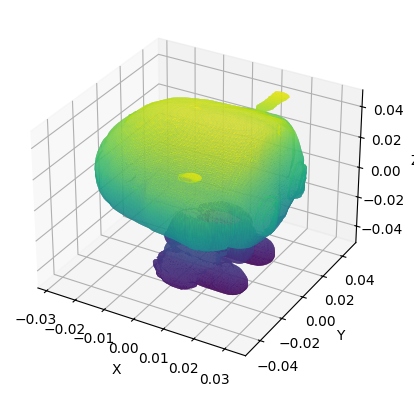

✅ TripoSR output saved to: /content/outputs/image_input/0/mesh.obj


In [9]:
# ==== Main ====
if __name__ == "__main__":
    text_prompt = input("Enter a text prompt (for TEXT-to-3D): ").strip()
    if text_prompt:
        run_shapee_text_to_3d(text_prompt)
    else:
        print("⚠️ No text prompt entered. Skipping Shap-E.")

    image_path = input("Enter image path (for IMAGE-to-3D): ").strip()
    if image_path and os.path.exists(image_path):
        run_triposr_image_to_3d(image_path)
    else:
        print(f"⚠️ Image not found at '{image_path}'. Skipping TripoSR.")